<a href="https://colab.research.google.com/github/Nilotpal1998/Natural-Language-Processing/blob/main/Bert_Exploration/BertSentenceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

## **Enabling GPU Training**

**Verifying the availability of GPU**

In [2]:
device_name=tf.test.gpu_device_name()
if device_name=='/device:GPU:0':
  print("Working on GPU")
else:
  print("GPU not found")


Working on GPU


In [3]:
import torch

**Setting The Device On CUDA**

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use the GPU : ", torch.cuda.get_device_name(0))
else:
  print("NO GPU available , using CPU instead.")
  device= torch.device("CPU")

There are 1 GPU(s) available.
We will use the GPU :  Tesla K80


In [5]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 36.0 MB/s 
     |████████████████████████████████| 636 kB 31.6 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=b3fedab0be52cdb971af082f9309d786c60141894a5d82e9af11a8e5d7c7b847
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


**Downloading and Extracting the CoLA Datatset**

In [7]:
import wget
import os
print("Downloading Dataset....")
url="https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
if not os.path.exists("./cola_public_1.1.zip"):
  wget.download(url,"./cola_public_1.1.zip") 

In [8]:
if not os.path.exists("./cola_public"):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


**Exploratory Data Analysis of CoLA Datasets**

In [9]:
import pandas as pd

In [10]:
df=pd.read_csv("./cola_public/raw/in_domain_train.tsv",delimiter="\t",header=None,names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [11]:
print("Number of Training sentences : {:,}\n".format(df.shape[0]))
df.sample(10)

Number of Training sentences : 8,551



,sentence_source,label,label_notes,sentence
6156,c_13,1,NaN,John seems to have left.
5927,c_13,0,*,John placed on the table.
2616,l-93,0,*,The change pocketed.
4659,ks08,0,*,They said him to be rich.
6193,c_13,1,NaN,I asked what John kissed.
4244,ks08,0,*,I washed me.
2227,l-93,1,NaN,This knife doesn't cut.
6898,m_02,1,NaN,The thief smashed the window with a hammer.
4464,ks08,0,*,John may rain.
700,bc01,0,*,John intimately spoke to Mary.


The two properties we actually care about are the the sentence and its label, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

In [12]:
print("The total Dataset length:",len(df))

The total Dataset length: 8551


In [13]:
correct=df.label.sum()
percent=correct/len(df)*100
print("The total percentage of gramatically correct data is :",percent,"%")

The total percentage of gramatically correct data is : 70.43620629166179 %


In [14]:
dict={"Correct":correct,"Incorrect":len(df)-correct}

In [15]:
dict

{'Correct': 6023, 'Incorrect': 2528}

In [16]:
import matplotlib.pyplot as plt


**Visualisation The Data**

Text(0.5, 0, 'Sentences Classes')

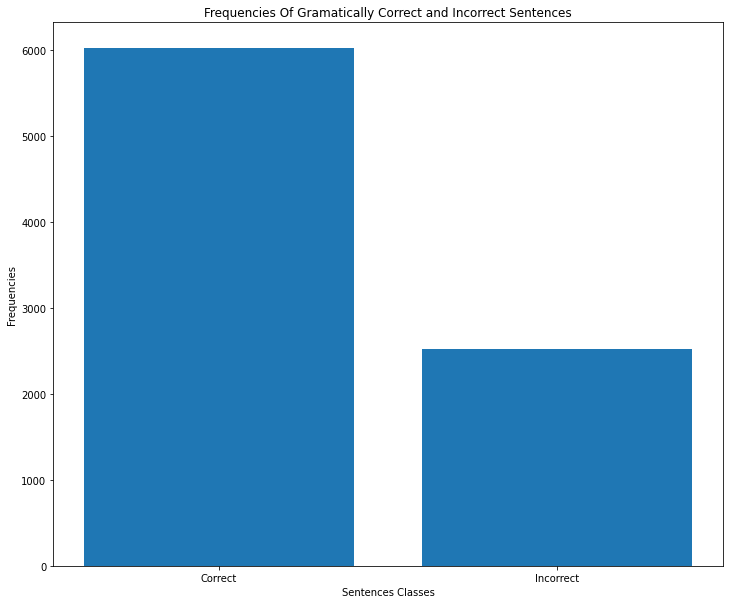

In [17]:
plt.figure(figsize=(12,10))
plt.bar(range(len(dict)), list(dict.values()), align='center')
plt.title("Frequencies Of Gramatically Correct and Incorrect Sentences")
plt.xticks(range(len(dict)), list(dict.keys()))
plt.ylabel("Frequencies")
plt.xlabel("Sentences Classes")

## **Tokenisation & Input Formatting**

In [18]:
from transformers import BertTokenizer
print("Loading.........")
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

Loading.........


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### **Tokenised ID's**

**Example**

In [19]:
print("Our Original Sentence:","I am a Footballer")
print("The Tokenised version :",tokenizer.tokenize("I am a Footballer"))
print("The Token IDs :" ,tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I am a Footballer")))

Our Original Sentence: I am a Footballer
The Tokenised version : ['i', 'am', 'a', 'footballer']
The Token IDs : [1045, 2572, 1037, 4362]


### **Required Formatting**

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

### **Sentences and Labels Extraction**

In [20]:
sentences=df.sentence.values
labels=df.label.values

In [21]:
sentences

array(["Our friends won't buy this analysis, let alone the next one we propose.",
       "One more pseudo generalization and I'm giving up.",
       "One more pseudo generalization or I'm giving up.", ...,
       'It is easy to slay the Gorgon.',
       'I had the strangest feeling that I knew you.',
       'What all did you get for Christmas?'], dtype=object)

In [22]:
labels

array([1, 1, 1, ..., 1, 1, 1])

## **Tokenisation And  Formatting**

In [23]:
max_len=0
for sent in sentences:
  input_ids=tokenizer.encode(sent,add_special_tokens=True)
  max_len=max(max_len,len(input_ids))
print("Max sentence Length:",max_len)

Max sentence Length: 47


In [24]:
input_ids

[101, 2054, 2035, 2106, 2017, 2131, 2005, 4234, 1029, 102]

In [25]:
input_ids=[]
attention_masks=[]
for sent in sentences:
  encoded_dict=tokenizer.encode_plus(
      sent,
      add_special_tokens = True,
      max_length=64,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors="pt"
  )
  input_ids.append(encoded_dict["input_ids"])
  attention_masks.append(encoded_dict["attention_mask"])
input_ids=torch.cat(input_ids,dim=0)
attention_masks=torch.cat(attention_masks,dim=0)
labels=torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
print("Original:",sentences[0])
print("Token_Ids:",input_ids[0])

Original: Our friends won't buy this analysis, let alone the next one we propose.
Token_Ids: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


### **Training And Validation Split**

In [27]:
from torch.utils.data import TensorDataset ,random_split
dataset = TensorDataset(input_ids,attention_masks,labels)

In [28]:
train_size=int(0.75*len(dataset))
val_size=len(dataset)-train_size

In [29]:
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [30]:
print("The train size is:",train_size)
print("The validation size is:",val_size)

The train size is: 6413
The validation size is: 2138


## **Data Loader**

In [31]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

In [32]:
batch_size=32
train_dataloader=DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

In [33]:
validation_dataloader=DataLoader(val_dataset,
                                 sampler=SequentialSampler(val_dataset),
                                 batch_size=batch_size)

## **Training**

In [34]:
from transformers import BertForSequenceClassification , AdamW , BertConfig

### **Model Architecture**

In [35]:
model=BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2,output_attentions=False,output_hidden_states=False)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### **Parametres**

In [36]:
params=list(model.named_parameters())
print("The total number of named parametres are:",len(params))
print("============== Embedding Layer==================== \n")
for p in params[0:3]:
  print(p[0],str(tuple(p[1].size())))
print("============== Norm Layer==================== \n")
for f in params[3:5]:
  print(f[0],str(tuple(f[1].size())))
print("============== First Transformer Layer==================== \n")
for p in params[5:21]:
  print(p[0],str(tuple(p[1].size())))
print("============== Output Layer==================== \n")
for p in params[197:201]:
  print(p[0],str(tuple(p[1].size())))

The total number of named parametres are: 201
============== Embedding Layer==================== 

bert.embeddings.word_embeddings.weight (30522, 768)
bert.embeddings.position_embeddings.weight (512, 768)
bert.embeddings.token_type_embeddings.weight (2, 768)
============== Norm Layer==================== 

bert.embeddings.LayerNorm.weight (768,)
bert.embeddings.LayerNorm.bias (768,)
============== First Transformer Layer==================== 

bert.encoder.layer.0.attention.self.query.weight (768, 768)
bert.encoder.layer.0.attention.self.query.bias (768,)
bert.encoder.layer.0.attention.self.key.weight (768, 768)
bert.encoder.layer.0.attention.self.key.bias (768,)
bert.encoder.layer.0.attention.self.value.weight (768, 768)
bert.encoder.layer.0.attention.self.value.bias (768,)
bert.encoder.layer.0.attention.output.dense.weight (768, 768)
bert.encoder.layer.0.attention.output.dense.bias (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight (768,)
bert.encoder.layer.0.attention.outpu

Here , we can see that there are two layers in our last layer since we will be using the dataset two conclude into two clases namely:-
1. Gramatically correct class 
2. Gramatically incorect class

## **Optimizer**

### **Stochastic Gradient Descent**

In [37]:
import torch.optim as optim 

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [39]:
#optimizer = AdamW(model.parameters(),lr =2e-5,eps=1e-8)

###  **Learning Rate Scheduler**

In [40]:
from transformers import get_linear_schedule_with_warmup
epochs=5
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= total_steps)

### **Training Loop**

#### **Helper Functions**

**Flat Accuracy**

In [41]:
import numpy as np
def flat_accuracy(preds,labels):
  pred_flat=np.argmax(preds,axis=1).flatten()
  labels_flat=labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

**Time Elapsed**

In [42]:
import time
import datetime

In [43]:
def format_time(elapsed):
  elapsed_time=int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_time))

In [44]:
import random

In [45]:
epochs

5

In [46]:
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values=[]

for epoch in range(0,epochs):
  #=========================================#
  #                Training                 #                      
  #=========================================#

  print("===================================== \n")
  print("The Epoch Number is :",epoch+1)
  print("Training........")


  t0=time.time()

  total_loss=0

  model.train()
  for step,batch in enumerate(train_dataloader):
    if step %40==0 and not step==0:
      elapsed =format_time(time.time()-t0)
      print("========================================================= \n")
      print("The Current Step is :",step)
      print("The Current Trainloader is :",len(train_dataloader))
      print("The Elapsed Time is :",elapsed)
      print("========================================================= \n")
    b_input_ids = batch[0].to(device)
    b_input_masks = batch[1].to(device)
    b_labels = batch[2].to(device) 

    model.zero_grad()

    outputs = model(b_input_ids,token_type_ids=None,attention_mask=b_input_masks,labels=b_labels)

    loss=outputs[0]

    total_loss+= loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
    optimizer.step()
    scheduler.step()
  avg_train_loss=total_loss/len(train_dataloader)
  loss_values.append(avg_train_loss)

  print("")
  print("Average training Loss : ", avg_train_loss)
  print(" Training epoch took : ",format_time(time.time()-t0)) 
  #=========================================#
  #                Validation               #                      
  #=========================================#
  print("")
  print("Running Validation ........ ")
  t0= time.time()
  total_loss=0
  model.eval()
  eval_loss, eval_accuracy = 0 , 0
  nb_eval_steps , nb_eval_examples = 0 , 0
  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids , b_input_masks , b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None , attention_mask = b_input_masks)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    labels_ids= b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits , labels_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps +=1
  print("Accuracy :", eval_accuracy/nb_eval_steps)
  print("Validation Time : ", format_time(time.time()-t0))
print("")
print("Training Complete.........!!!!!!!!!!!!")


The Epoch Number is : 1
Training........


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



The Current Step is : 40
The Current Trainloader is : 201
The Elapsed Time is : 0:00:25


The Current Step is : 80
The Current Trainloader is : 201
The Elapsed Time is : 0:00:49


The Current Step is : 120
The Current Trainloader is : 201
The Elapsed Time is : 0:01:14


The Current Step is : 160
The Current Trainloader is : 201
The Elapsed Time is : 0:01:39


The Current Step is : 200
The Current Trainloader is : 201
The Elapsed Time is : 0:02:03


Average training Loss :  0.5315592898361718
 Training epoch took :  0:02:04

Running Validation ........ 
Accuracy : 0.7898249138920781
Validation Time :  0:00:14

The Epoch Number is : 2
Training........

The Current Step is : 40
The Current Trainloader is : 201
The Elapsed Time is : 0:00:25


The Current Step is : 80
The Current Trainloader is : 201
The Elapsed Time is : 0:00:49


The Current Step is : 120
The Current Trainloader is : 201
The Elapsed Time is : 0:01:14


The Current Step is : 160
The Current Trainloader is : 201
The Elapse

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Loss')

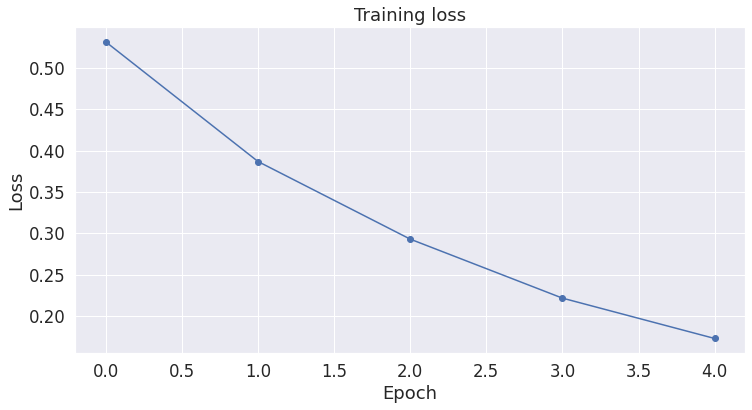

In [48]:
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"]=(12,6)
plt.plot(loss_values,"b-o")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### **Test Dataset**

#### **Loading The Dataset**

In [49]:
import pandas as pd

In [50]:
df_test=pd.read_csv("cola_public/raw/out_of_domain_dev.tsv",delimiter='\t',header=None,names=['sentence_source', 'label', 'label_notes', 'sentence'])
print("The Number of Sentences in the Test Dataset: ", df_test.shape[0])

The Number of Sentences in the Test Dataset:  516


#### **Tokenisation of Test Dataset**

In [51]:
from keras.preprocessing.sequence import pad_sequences

In [52]:
sentences=df_test.sentence.values
labels=df_test.label.values
input_test_ids=[]
for sent in sentences:
  encoded_sent=tokenizer.encode(sent,add_special_tokens=True)
  input_test_ids.append(encoded_sent)
input_ids=pad_sequences(input_test_ids,maxlen=64,dtype="long",truncating="post",padding="post")
attention_masks=[]
for seq in input_test_ids:
  seq_masks=[float(i>0) for i in seq]
  attention_masks.append(seq_masks) 

#### **Convert To Tensor**

In [53]:
import torch

In [54]:
prediction_inputs=torch.tensor(input_ids)
#prediction_masks=torch.tensor(attention_masks)
prediction_labels=torch.tensor(labels)

In [55]:
df = pd.read_csv("cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Number of test sentences: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=64, 
                          dtype="long", truncating="post", padding="post")


attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)


batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [56]:
print("Initiating Testing.......")
model.eval()
predictions,true_labels=[],[]
for batch in prediction_dataloader:
  batch=tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
print("Done...........!!!!!!!!!!")

Initiating Testing.......
Done...........!!!!!!!!!!


In [65]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [60]:
preds=[]
for i in predictions:
  for j in range(len(i)):
    preds.append(np.argmax(i[j]))
print(preds)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 

In [61]:
len(preds)

516

In [63]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [64]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

Total MCC: 0.509
